# Finding Critical Points with TensorFlow
## Part 1b - Critical Points of Quadratic Forms - Gradient Norm Minimzation

An alternative, possibly more intuitive, method of finding critical points
is to simply minimize the norm of the gradient directly.

That is, we are interested in points where the gradient is close to the $0$ vector.
To find these points,
we descend a new function $g$
that is defined in terms of the
gradients of our original function:

$$
g(\theta) = \frac{1}{2}\|\nabla f(\theta) \|_2^2
$$

A quick application of the chain rule gives the following:

$$\begin{align}
\nabla g(\theta) &= \nabla\|\nabla f(\theta) \|_2^2\\
&= \nabla\nabla f(\theta)\cdot \nabla f(\theta)\\
&= \nabla^2f(\theta)\nabla f(\theta)
\end{align}$$

leading to the update rule:

$$\begin{align}
\theta^{t+1} &= \theta^{t} - \eta \nabla g(\theta)\\
&= \theta^{t} - \eta\nabla^2f(\theta)\nabla f(\theta)
\end{align}$$

Compare this to the Newton update:

$$\begin{align}
\theta^{t+1} &= \theta^{t} - \gamma \left(\nabla^2f(\theta)\right)^{-1}\nabla f(\theta)
\end{align}$$

Despite the intuitive appeal of the former method,
an analysis of its performance on polynomial functions
would seem to indicate that it is a *bad idea*,
because it converges more slowly when the step size is correctly chosen
and diverges horribly if it is not.

It is unclear, however, whether this carries over to other kinds of functions.

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np

import crit_finder

%matplotlib inline

### Testing with Identity Matrix

The identity matrix quadratic form also makes a sanity check for the gradient norm minimization technique,
since the Hessian is the identity,
and so the updates from gradient norm minimization should exactly match those
from gradient descent.

In [2]:
N = 2

identity_matrix = np.eye(N).astype(np.float32)

initial_values = np.random.standard_normal(size=N).astype(np.float32)

identity_quadratic_form = crit_finder.make_quadratic_form(identity_matrix, initial_values,
                                                                 crit_finder.DEFAULTS)

In [3]:
gradmin_final_output, gradmin_final_parameters = crit_finder.minimize(identity_quadratic_form, "gradient_norm_min", 50)
gradmin_final_output, gradmin_final_parameters

(2.9315233e-05, array([0.00741813, 0.00189783], dtype=float32))

In [4]:
gd_final_output, gd_final_parameters = crit_finder.minimize(identity_quadratic_form, "gradient_descent", 50)

gd_final_output, gd_final_parameters

(2.9315233e-05, array([0.00741813, 0.00189783], dtype=float32))

In [5]:
assert all(np.equal(gradmin_final_parameters, gd_final_parameters))

### Random Symmetric Matrix

We again first extend to the case of random symmetric matrices
(for more on the specific random ensemble, see
[the previous notebook](./01a - Critical Points of Quadratic Forms - Newton's Method.ipynb)).

In [6]:
def generate_gaussian(N):
    return 1/np.sqrt(N)*np.random.standard_normal(size=(N,N)).astype(np.float32)

def generate_symmetric(N):
    base_matrix = generate_gaussian(N)
    return (1/np.sqrt(2))*(base_matrix+base_matrix.T)

In [7]:
N = 5

initial_values = 1/np.sqrt(N)*np.random.standard_normal(size=N).astype(np.float32)

random_symmetric_matrix = generate_symmetric(N)

random_symmetric_quadratic_form = crit_finder.make_quadratic_form(random_symmetric_matrix, initial_values,
                                                                 crit_finder.DEFAULTS)

_, values = crit_finder.minimize(random_symmetric_quadratic_form, "gradient_norm_min", 5000)

np.linalg.norm(values)

6.327518e-05

Despite also using curvature information,
gradient norm minimization takes *far* more steps to reach a given error than
does Newton's method:
while Newton can get to solutions with norm of order `1e-8` in two or three steps,
gradient norm minimization takes thousands of steps even on small problems,
with the number of steps increasing with problem size.

### Random Positive Definite Matrix

The advantage of gradient norm minimization,
however, is that it does not require a matrix inverse calculation.

This has a computational benefit,
since the matrix inversion step is complexity $O(n^{k})$
for some $k$ in $(2, 3]$,
depending on the algorithm,
while all other computational steps are at most complexity $O(n^2\log n)$.

But even more crucially,
avoiding the matrix inverse means that all of the issues regarding numerical non-invertibility
that bedeviled the Newton's methods discussed in the last notebook
are avoided.

We again select random ill-conditioned matrices
according to the Wishart distribution.

In [8]:
def generate_wishart(N):
    self_outer_product = lambda x: x.dot(x.T)
    wishart_random_matrix = 1/N*self_outer_product(np.random.standard_normal(size=(N,1))).astype(np.float32)
    
    return wishart_random_matrix

In [9]:
N = 500

wishart_random_matrix = generate_wishart(N)

initial_values = 1/np.sqrt(N)*np.random.standard_normal(size=N).astype(np.float32)

wishart_quadratic_form = crit_finder.make_quadratic_form(wishart_random_matrix, initial_values,
                                                                 crit_finder.DEFAULTS)

Interestingly, we discover that gradient descent and gradient norm minimization
end up at almost exactly the same (wrong) solution!

In [10]:
_, gd_solution = crit_finder.minimize(wishart_quadratic_form, "gradient_descent", 500)
_, gradient_norm_min_solution = crit_finder.minimize(wishart_quadratic_form, "gradient_norm_min", 500)

np.linalg.norm(gd_solution-gradient_norm_min_solution)

3.5077608e-07

How could this be?

For a quadratic form
$$f(x) = \frac{1}{2}\theta^\intercal Q \theta$$
denote by $M$ the Hessian matrix
$$\nabla^2 f(\theta) = \frac{1}{2}(Q+Q^\intercal)\ \colon=M$$
and recall that the gradient is
$$\nabla f(\theta) = M\theta$$

Assuming WLOG that the step size is $1$,
the gradient descent update is
$$
\theta^{t+1} = \theta^{t} - \nabla f(\theta) = \theta^t - M\theta
$$

while the gradient norm minimization update is

$$
\theta^{t+1} = \theta^{t} - \nabla^2 f(\theta) \nabla f(\theta) = \theta^{t} - MM\theta$$

And so for the updates to be approximately equal we need to have

$$
MM\theta \approx M\theta \ \ \ \forall \theta \\
\therefore M^2 \approx M
$$

The condition of exact equality there is called
[idempotence](https://en.wikipedia.org/wiki/Idempotent_matrix).
A matrix is idempotent if
(and perhaps only if, but I haven't rigorously proved this)
its eigenvalues are all $0$ or $1$.

This is almost surely not exactly the case for our matrices,
but then again,
we saw that the updates weren't exactly equal.
Let's take a look at the spectrum of $M$.

In [11]:
Q = wishart_random_matrix

M = 0.5*(Q+Q.T)

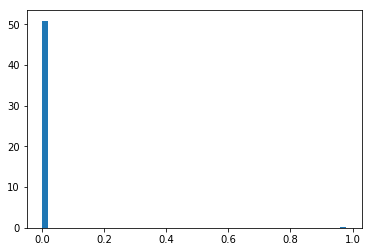

In [12]:
plt.hist(np.linalg.eig(M)[0], normed=True, bins=50);

Indeed, the eigenvalues are all close to $0$ or $1$.

We can also check out conditions directly.

In [13]:
np.linalg.norm(M.dot(M)-M)

0.019451223

In [14]:
np.linalg.norm(M.dot(M).dot(initial_values) - M.dot(initial_values))

0.0015909893

And so not only does gradient norm minimization use more computational effort than gradient descent,
it does so while also making almost the exact same updates as gradient descent for certain problems!